<a href="https://colab.research.google.com/github/ArezooAalipanah/learning-from-human-preferences/blob/master/Deep_RL_with_Human_Preferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

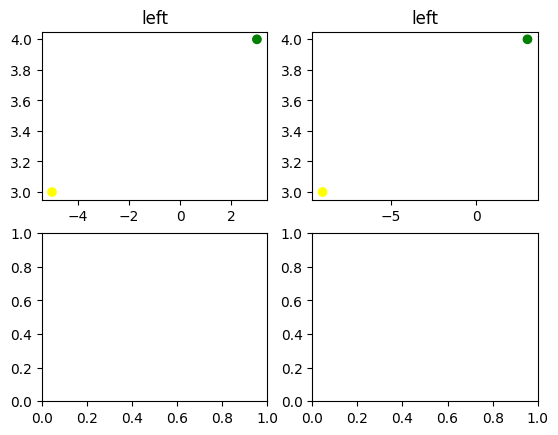

episode:  0
average steps to target  25.0


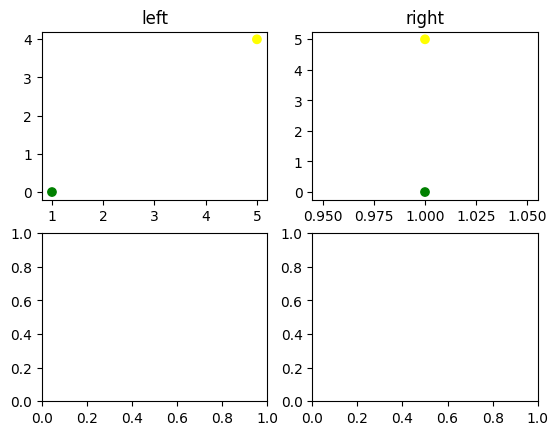

episode:  1
average steps to target  25.0


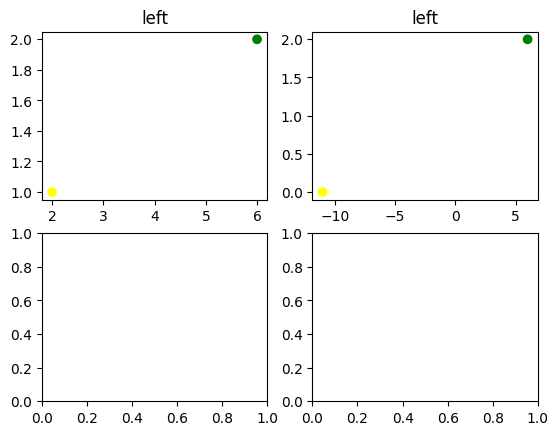

episode:  2
average steps to target  25.0


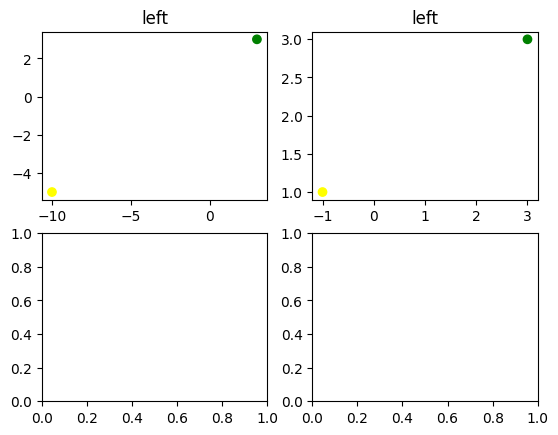

episode:  3
average steps to target  25.0


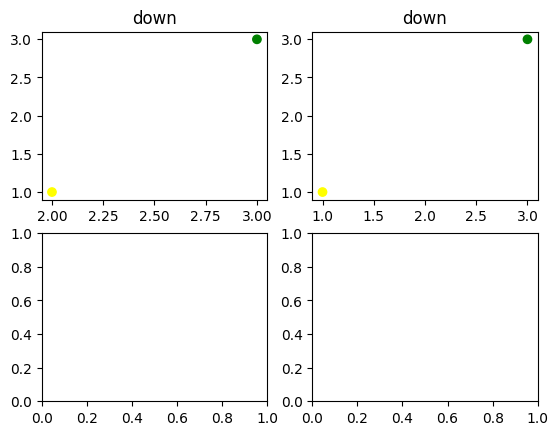

episode:  4
average steps to target  25.0


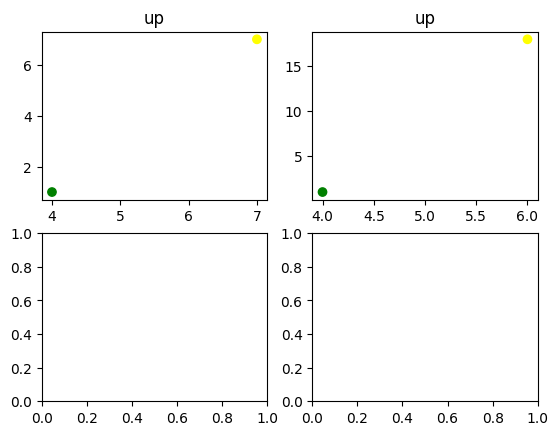

episode:  5
average steps to target  25.0


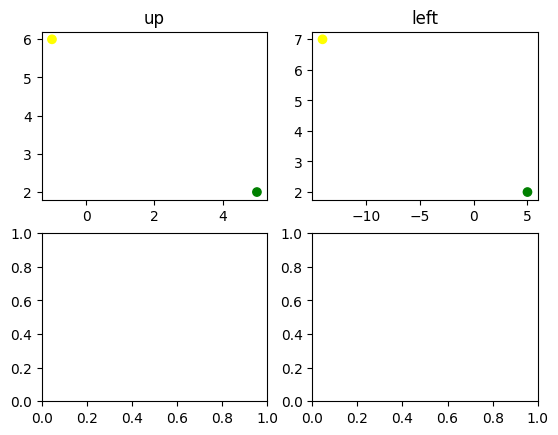

episode:  6
average steps to target  25.0


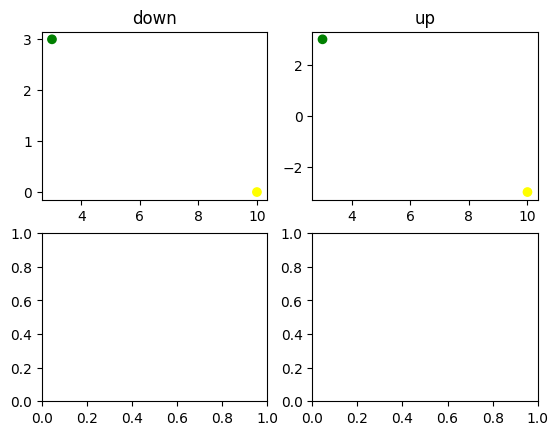

episode:  7
average steps to target  25.0


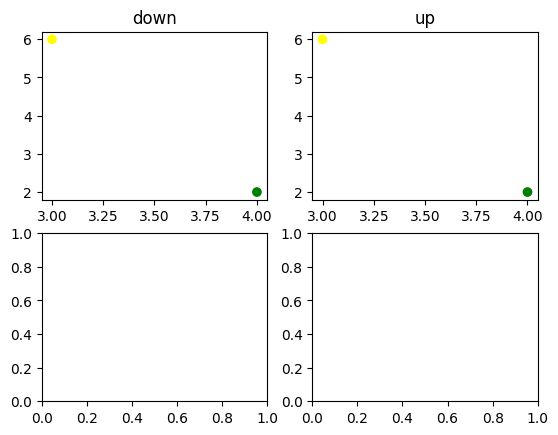

episode:  8
average steps to target  25.0


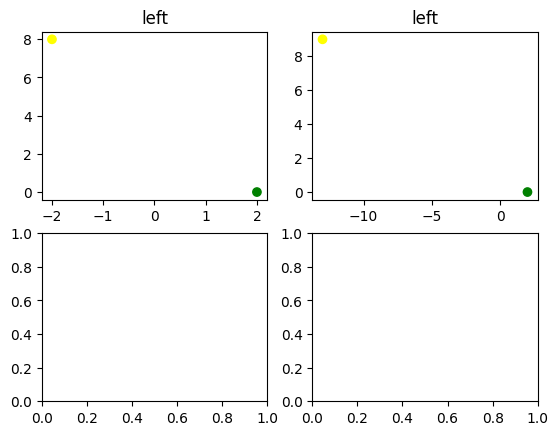

episode:  9
average steps to target  25.0


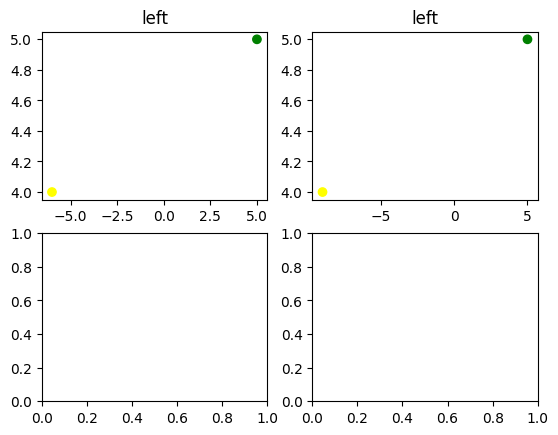

episode:  10
average steps to target  25.0


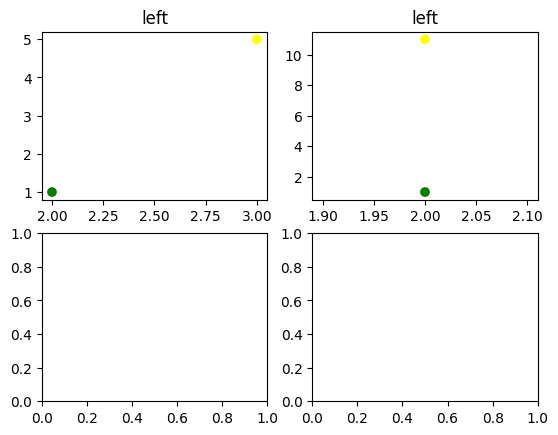

episode:  11
average steps to target  25.0


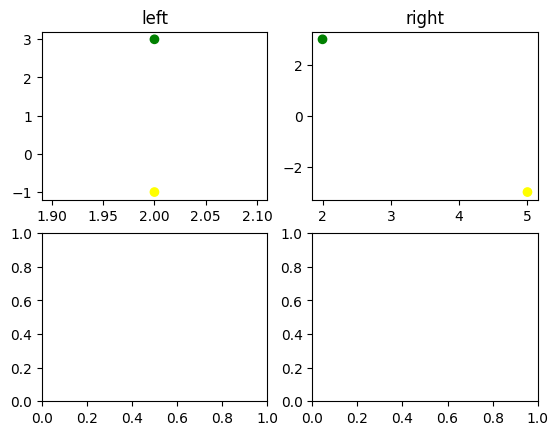

episode:  12
average steps to target  25.0


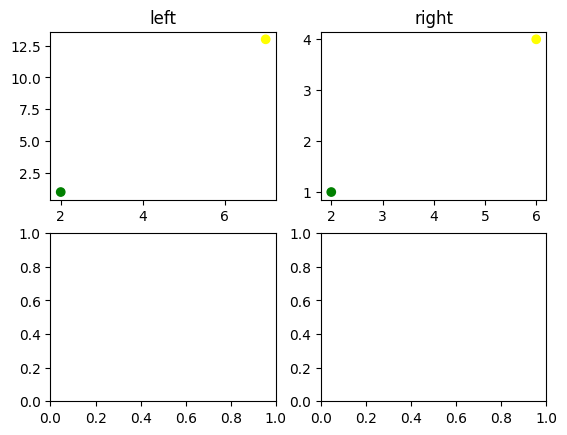

KeyboardInterrupt: ignored

In [3]:
#first we have to import the necessary libraries and stuff
import numpy as np
import random
import statistics
import tensorflow as tf
from tensorflow.keras import layers

#then we should go to out environment
"""previously we would have a reward function and based on the conditions we 
would hand specify the reward.(eg. using positive or negative rewards to show 
the agent that its actions were good/ not so good. )
but here we are going to use a learned reward fuction which is going to be a NN.
"""

"""
the environment is the same everywhere. It is just a simple gridworld environment
and we define 2 points in a 2d plane
"""
class Gridworld():
  def __init__(self):
    self.state = self.init_state()
    self.step_count = 0

  def init_state(self):
    #player points: start points are xs and ys
    xs = random.sample(range(0,7),5)
    ys = random.sample(range(0,7),5)
    #goal piece
    piece1 = [xs[0], ys[0]]
    playerpos = [xs[4],ys[4]]
    positions = list(np.array([playerpos, piece1]).flatten())
    return positions

  def reset (self):
    self.state = self.init_state()
    self.step_count = 0

  def step(self, action):
    self.step_count +=1
    if action ==0: #up: change the y to be 1 more
       self.state[1] +=1
      
    if action == 1:#right
      self.state[0] +=1

    if action ==2:#down
      self.state[1] -=1

    if action == 3:#left
      self.state[0] -=1

    """ here we are using a learned reward function which is going to be a neural 
    network as "rewarder" in order to set the rward"""
    """
    our reward function: 
    previously we would look at the state we are in and decide the reward based
    on that.
    here it's gonna take a look at what state we are in and estimate what our 
    reward is gonna be.
    here we will call our reward fuction on the state of the environment 
    so let's say rewarder is our NN which estimates a reward. we are going to pass
    the current state (training is false) and we will look at it and it will give
    us a prediction(-> so we should get the 0th index)
    """
    if (self.step_count >=25): #loss_max_step
      self.reset()
      reward = int(rewarder(tf.expand_dims(self.state, 0), training = False)[0])
      playing = False
      return reward , playing

    if (self.state[0] ==self.state[2] ) and (self.state[1] == self.state[3]): 
      #termination success condition
      playing = False
      reward = int(rewarder(tf.expand_dims(self.state, 0), training = False)[0])
      self.reset()
      return reward, playing

    playing = True
    reward = int(rewarder(tf.expand_dims(self.state, 0), training = False)[0])
    return reward, playing


"""here is our agent which is an actor agent for the Reinforce algorithm
it takes number of actions and number of hidden units 
we define a layer with the number of hidden units and we let the output layer be 
the number of actions and we select the actions from that output layer"""
class Actor(tf.keras.Model):
  def __init__(self, num_actions, num_hidden_units ):
    super().__init__()

    self.shared_1 = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
  
  """ when we call we take the input observation and we pass that through shared1
  whhich is the first layer(X) then we have our output as the output layer on x """

  def call(self, input_obs):
    x = self.shared_1(input_obs)
    return self.actor(x)

""" the rewarder class is very similar to the actor itself. except for the fact 
that the last layer(output) is a single unit -reward. because it is just 
predicting scalar rewards for the output. (kind of like a critic but with a 
different update reward."""

class Rewarder(tf.keras.Model):
  def __init__(self, num_hidden_units ):
    super().__init__()

    self.shared_1 = layers.Dense(num_hidden_units, activation="relu")
    self.reward = layers.Dense(1)

  def call(self, input_obs):
    x = self.shared_1(input_obs)
    return self.reward(x)

#instatiate the agent, the rewarder and the gridworld

agent = Actor(num_actions= 4, num_hidden_units= 100)

rewarder = Rewarder(num_hidden_units=100)

env = Gridworld()

def calc_g( reward_trajectory , gamma ):
  ez_discount = np.array([ gamma**n for n in range(len(reward_trajectory))])
  gs = []
  reward_trajectory = np.array(reward_trajectory)
  for ts in range(len(reward_trajectory)):
    to_end_rewards = reward_trajectory[ts:]
    eq_len_discount = ez_discount[:len(reward_trajectory[ts:])]
    total_value = np.multiply(to_end_rewards , eq_len_discount )
    g = sum(total_value)
    gs.append(g)
  return gs

""" we are gonna be training the reward fuction on s and a, and it ends up in 
the next state.
so if we are going to sum over all of them we could use the entire trajectory.
gut here, we just use the single states. 
so we take the single state and the action and it needs to know the reward for 
being in the next state. 
"""

""" so we need to keep track of states and actions. 
we have 2 lists called states and actions 

then we have used the categorical distribution to have the index of the action.
(using tf.random.) we will recieve the action from it. """

#basically we run the agent based on observation and we recieve some actions
# possible in that observation. then we run a distribution to get the action
#index based on that. 

def step_episode(env, model):
  env.reset()
  action_probs_list = []
  rewards = []
  states = []
  actions = []
  playing = True
  while playing == True:
    obs = tf.expand_dims (env.state , 0)
    #run model to get action logits and value
    action_logits = agent(obs)
    # categorical probabilistic action idx selection
    selected_action_idx = tf.random.categorical(action_logits, 1)[0 , 0]

    """
    once we have selected the action we should take the state that we were in 
    and append that.(to the list)
    and our current action equals to the selected action
    """

    states.append(obs)
    actions.append(selected_action_idx)


    reward , playing = env.step(selected_action_idx)
    #normlized probs
    action_probs =  tf.nn.softmax(action_logits)
    probability_of_taking_selected_action = action_probs[0, selected_action_idx]
    action_probs_list.append(probability_of_taking_selected_action)
    rewards.append(reward)

  return action_probs_list, rewards, states, actions

# same as standard reinforce
def actor_loss(action_probs, rewards):
  #log of pi(a |s)
  gs = calc_g(rewards, .99)
  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs* gs)
  return actor_loss

optimizer0 = tf.keras.optimizers.Adam(learning_rate=.0005)
optimizer1 = tf.keras.optimizers.Adam(learning_rate=.0005)

  
"""using matplotlib here we are building a very simple user interface so the user 
can see 2 different states and the actions on that states. so they can choose 
which one they prefer(left, right, same"""

def compare(transition_ids, states, actions ):
  d1xs=[states[transition_ids[0]][0][0], states[transition_ids[0]][0][2]]
  d1ys=[states[transition_ids[0]][0][1], states[transition_ids[0]][0][3]]
  d2xs=[states[transition_ids[1]][0][0], states[transition_ids[1]][0][2]]
  d2ys=[states[transition_ids[1]][0][1], states[transition_ids[1]][0][3]]

  fig, ax = plt.subplots(2,2)
  colors = ["yellow", "green"]
  color_indices = [0, 1, ]
  colormap = matplotlib.colors.ListedColormap(colors)
  ax[0, 0].scatter(d1xs, d1ys, c = color_indices, cmap = colormap )  #top left
  ax[0, 0].set_title(str(decode_action(actions[transition_ids[0]].numpy())))
  ax[0, 1].scatter(d2xs, d2ys, c = color_indices, cmap = colormap )  #top right
  ax[0, 1].set_title(str(decode_action(actions[transition_ids[1]].numpy())))
  plt.show()

def decode_action(action):
  if action == 0:
    return "up"
  if action == 1:
    return "right"   
  if action == 2:
    return "down"
  if action == 3:
    return "left"


""" the fuction pref update is the one responsible for updating the rewards 
based on the user preferences.
we recieve state and action trajectories and we need to sample some states 
that we are gonna compare.
in the paper itself they used a segment of that trajectory. here we use individual 
states.=> so it used ensembles to say whenever there is uncertainty between 
different models the comparison happens."""



def preference_update(states, actions, rewarder):
  #the rewarder needs to be optimized.
  """ we will get some ids from random sample"""
  transition_ids = random.sample(range(0, len(states) - 2), 2)
  # we send the parts to the compare function so the user can see them and select
  compare(transition_ids, states, actions)
  pref = input( "select preference: a:left d:right s:same ? ")
  if pref == "a":
    dist = [1, 0]

  if pref == "d":
    dist = [0, 1]
  
  if pref == "s":
    dist = [1, 1] 

  with tf.GradientTape() as tape :
    # the "+1" bellow is for we want to end up in the next state.
    reward1 = rewarder(states[transition_ids[0]+ 1])
    reward2 = rewarder(states[transition_ids[1]+ 1])
    p1 = tf.exp(reward1) / (tf.exp(reward1)+tf.exp(reward2))
    p2 = tf.exp(reward2) / (tf.exp(reward1)+tf.exp(reward2))
    # the loss is between the probabilities we have based on the reward predictor 
    # and what the user has selected.
    loss= - (tf.math.log(p1) * dist[0] + tf.math.log(p2) * dist[1])
  
  # having the loss we update our trainable variables base on the loss
  grads = tape.gradient(loss, rewarder.trainable_variables)
  optimizer0.apply_gradients(zip(grads, rewarder.trainable_variables))


average_len = []
""" so we run an entire episode and then at the end of the episode we run the 
pref update and it selects 2 random states and shows it to the user to choose"""
for episode in range(5000):
  with tf.GradientTape() as tape:
    action_probs , rewards , states , actions = step_episode(env, agent)
    loss = actor_loss(action_probs, rewards)
  grads = tape.gradient(loss, agent.trainable_variables)
  optimizer1.apply_gradients(zip(grads, agent.trainable_variables))
  average_len.append(len(rewards)) # adds episodes average rewards

  preference_update(states, actions, rewarder)

  print("episode: ", episode)
  print("average steps to target " , np.mean(average_len[-100:]))


  
    